In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, ndimage
import pykrige as pk
from IPython import display
import time

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [4]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)

Test data shape:  (4, 320, 256, 256)


In [5]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [6]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [29]:
def denoise(sparse_measurement, mask, model, steps=1000):
    betas = torch.linspace(1e-4, 0.02, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    x_t_unknown = torch.randn_like(sparse_measurement).to(device)
    for t in reversed(range(1, steps+1)):
        assert x_t_unknown.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
        # Calculate the parameters
        alpha_t_bar = alphas_cumprod[t-1]
        beta_t = betas[t-1]
        alpha_t = alphas[t-1]
        # Predict the noise using the model
        with torch.no_grad():
            epsilon_theta = model(x_t_unknown)

        # Make sure the output of the model (the predicted noise) has a single channel
        assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."
        # Calculate the mean of the previous step in the backward process of diffusion model
        mean = (1 / torch.sqrt(alpha_t)) * (x_t_unknown - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
        # Add noise for all but the last step (strictly follow the algorithm)
        if t > 1:
            # z = torch.randn_like(x_t).to(device)
            z = torch.randn_like(x_t_unknown).to(device)
            x_t_unknown = mean + torch.sqrt(beta_t) * z
        else:
            x_t_unknown = mean
        z2 = torch.randn_like(x_t_unknown)
        x_t_known  = torch.sqrt(alpha_t_bar) * sparse_measurement + torch.sqrt(1 - alpha_t_bar) * z2
        x_t = mask * x_t_known + (1 - mask) * x_t_unknown
        if t%100 == 0
            plt.imshow(x_t.squeeze().cpu())
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)
                
    #plt.imshow(guidance.squeeze().cpu())
    #plt.show()
    return x_t

KeyboardInterrupt: 

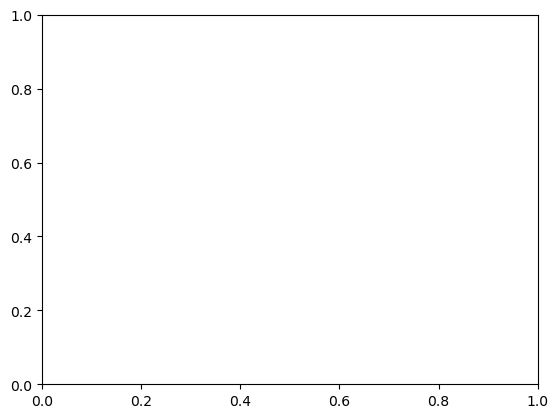

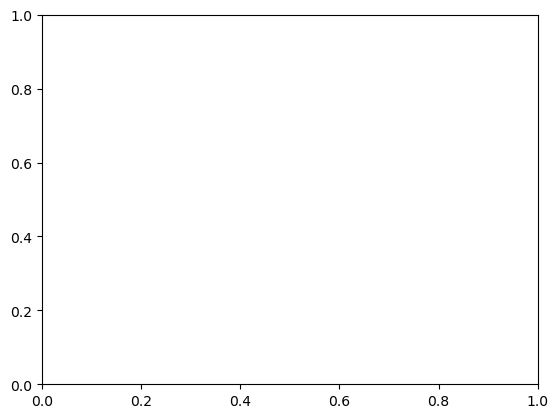

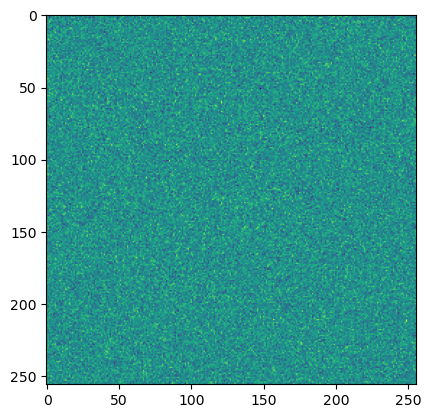

In [30]:
# Choose snapshot from test dataset: [4, 320, 256, 256] by changing the first dimension and the second dimension
# Make sure that the first and the second dimensions are within the range of the test dataset
test_snapshot = test_data[1, 110, :, :] # 1 and 110 are chosen here, you change them to get different snapshots
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

percentage = 1.56
factor = percentage/100
N = int(256**2 * factor)
test_snapshot = test_data[1, 5, :, :]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
hard_mask = np.zeros_like(test_snapshot)
hard_mask[nx, ny] = 1
print(np.sum(hard_mask), nx, ny.shape)

#krig = pk.OrdinaryKriging()
#ax.scatter(xx*mask, yy*mask, s=10, c="black")

mask = ndimage.gaussian_filter(hard_mask, 2)
#mask[hard_mask == 1] = 1

xx,yy = np.meshgrid(np.arange(256), np.arange(256))

sparse_measurements = hard_mask * test_snapshot

coordinates_tuple = np.where(sparse_measurements > 1e-10)
sparse_measurements = sparse_measurements[sparse_measurements > 1e-10]
coordinates = np.vstack(coordinates_tuple).T
sparse_measurements = interpolate.griddata(coordinates, sparse_measurements, (xx,yy), method='nearest').T
sparse_measurements = torch.tensor(sparse_measurements, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

mask = torch.tensor(mask, dtype=torch.float32).to(device)
generated_image = denoise(sparse_measurements, mask, model,steps=300)

sparse_measurements = sparse_measurements.squeeze().detach().cpu().numpy()
#print(sparse_measurements)
#sparse_measurements[sparse_measurements > 1e-10] = None
ax.imshow(sparse_measurements)
ax2.imshow(generated_image.squeeze().cpu())
ax3.imshow(test_snapshot)